In [634]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [635]:
# загрузка данных
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)


In [636]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))
train_img_small = train_img
test_img_small = test_img


In [637]:
train_img.shape

(42000, 28, 28)

In [638]:
test_img.shape

(28000, 28, 28)

In [639]:
train_img_small.shape

(42000, 28, 28)

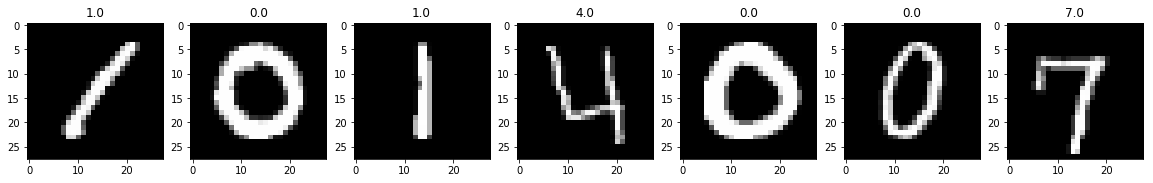

In [640]:
fig = plt.figure(figsize=(20, 20))
for i, img in enumerate(train_img_small[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [641]:

train_sobel_x = np.zeros_like(train_img_small)
train_sobel_y = np.zeros_like(train_img_small)


In [642]:
train_sobel_x.shape, train_sobel_y.shape

((42000, 28, 28), (42000, 28, 28))

In [643]:
for i in range(len(train_img_small)):
    train_sobel_x[i] = cv2.Sobel(train_img_small[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img_small[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

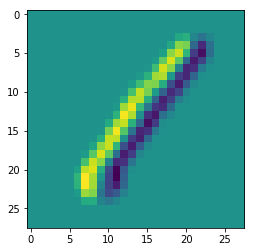

In [644]:
plt.imshow(train_sobel_x[0])

In [645]:
test_sobel_x = np.zeros_like(test_img_small)
test_sobel_y = np.zeros_like(test_img_small)
for i in range(len(test_img_small)):
    test_sobel_x[i] = cv2.Sobel(test_img_small[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img_small[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [646]:
train_g_1, train_theta_1 = cv2.cartToPolar(train_sobel_x, train_sobel_y)


In [647]:
np.count_nonzero(train_theta_1)

10277141

In [648]:
test_g_1, test_theta_1 = cv2.cartToPolar(test_sobel_x, test_sobel_y)


In [649]:
train_hist = np.zeros((42000,16))

In [650]:
# Гистограммы вычисляются с учетом длины вектора градиента
for i in range(len(train_img_small)):
    hist_1, borders_1 = np.histogram(train_theta_1[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g_1[i])
    train_hist[i] = hist_1
    
#     train_hist[i] = np.roll(hist_1, -hist_1.argmax())
# пробовал сдвигать гистограмму с максимумом в начало, но это ухудшает результат

    
        
        

In [651]:
# проверка положения наибольшего значения в гистограмме
sss = [train_hist[i].argmax() for i in range(20)]

In [652]:
sss

[9, 14, 0, 15, 6, 0, 0, 3, 11, 11, 10, 9, 8, 4, 11, 0, 4, 1, 9, 4]

In [653]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img_small)):
    hist_1, borders_1 = np.histogram(test_theta_1[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g_1[i])
    test_hist[i] = hist_1


In [654]:
from sklearn.preprocessing import StandardScaler

In [655]:
np.count_nonzero(np.resize(test_hist,(2*28*1000*16,1)))

890484

In [656]:
test_hist_stacked.shape

(28000, 32)

In [657]:
# нормализация гистограмм
scaler = StandardScaler()
train_hist_scaled = scaler.fit_transform(train_hist)

test_hist_scaled = scaler.fit_transform(test_hist)


In [658]:
train_hist.shape

(42000, 16)

In [659]:
# генерация 10 кластеров
centroids = np.zeros((10, train_hist_scaled.shape[1]), dtype=np.float32)

In [660]:
centroids.shape

(10, 16)

In [661]:
# вычисление среднего значения для каждого кластера
for i in range(10):
    centroids[i] = np.mean(train_hist_scaled[train_label == i], axis=0)

In [662]:
# предсказания значений
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist_scaled[i], axis=1)
    pred_test[i] = np.argmin(distances)

In [663]:
with open('submit_3_1.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))